### Import Library

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE
from xgboost import XGBClassifier
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")

### --- Step 1: Load all extracted feature files ---

In [71]:
data_dir = "../data/processed"  # Preprocessed data with windows
results_dir = "../data/results/Autoencoder_XGB"
os.makedirs(results_dir, exist_ok=True)

subjects = [f"chb{str(i).zfill(2)}" for i in range(1, 25)]
RANDOM_STATE = 67
USE_SMOTE = True
BALANCE_STRATEGY = "borderline"  # Options: "smote", "borderline", "adasyn", "svm"
BATCH_SIZE = 1024
EPOCHS = 250
LEARNING_RATE = 5e-4

sns.set_theme(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Subjects:", subjects)
print("Results directory:", results_dir)

Subjects: ['chb01', 'chb02', 'chb03', 'chb04', 'chb05', 'chb06', 'chb07', 'chb08', 'chb09', 'chb10', 'chb11', 'chb12', 'chb13', 'chb14', 'chb15', 'chb16', 'chb17', 'chb18', 'chb19', 'chb20', 'chb21', 'chb22', 'chb23', 'chb24']
Results directory: ../data/results/Autoencoder_XGB


In [72]:
# Quick data sanity check
label_dir = "../data/features"
print("\nData label distribution per subject:")
for s in subjects:
    y_path = os.path.join(label_dir, s, f"y_labels_{s}.npy")
    if os.path.exists(y_path):
        y = np.load(y_path)
        counts = np.bincount(y)
        print(f"{s}: non-seizure={counts[0]}, seizure={counts[1] if len(counts)>1 else 0}")


Data label distribution per subject:
chb01: non-seizure=19427, seizure=38
chb02: non-seizure=16912, seizure=15
chb03: non-seizure=18206, seizure=34
chb04: non-seizure=74890, seizure=13
chb05: non-seizure=18679, seizure=42
chb06: non-seizure=32032, seizure=0
chb07: non-seizure=32183, seizure=0
chb08: non-seizure=9603, seizure=0
chb09: non-seizure=32573, seizure=0
chb10: non-seizure=24008, seizure=0
chb11: non-seizure=16700, seizure=0
chb12: non-seizure=11371, seizure=0
chb13: non-seizure=5760, seizure=0
chb14: non-seizure=12480, seizure=0
chb15: non-seizure=19204, seizure=0
chb16: non-seizure=8160, seizure=0
chb17: non-seizure=9603, seizure=0
chb18: non-seizure=16623, seizure=0
chb19: non-seizure=13885, seizure=0
chb20: non-seizure=13245, seizure=0
chb21: non-seizure=15757, seizure=0
chb22: non-seizure=14881, seizure=0
chb23: non-seizure=12745, seizure=0
chb24: non-seizure=10174, seizure=48


In [73]:
# -------------------------------
# Autoencoder Definition
# -------------------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

### --- Step 2: Helper functions ---

In [74]:
# -------------------------------
# Load subject data
# -------------------------------
def load_subject_data(subject, max_windows=None):
    subj_dir = os.path.join(data_dir, subject)
    X_files = sorted([f for f in os.listdir(subj_dir) if f.startswith("X_")])
    y_files = sorted([f for f in os.listdir(subj_dir) if f.startswith("y_")])

    X_list, y_list = [], []
    for xf, yf in zip(X_files, y_files):
        # Load slice partially
        X_loaded_full = np.load(os.path.join(subj_dir, xf)).astype(np.float32)
        y_loaded_full = np.load(os.path.join(subj_dir, yf)).astype(np.float32)
        
        # Reduce slice size if too large
        n_windows = X_loaded_full.shape[0]
        if max_windows is not None and sum([x.shape[0] for x in X_list]) + n_windows > max_windows:
            remain = max_windows - sum([x.shape[0] for x in X_list])
            if remain <= 0:
                break
            X_loaded = X_loaded_full[:remain]
            y_loaded = y_loaded_full[:remain]
        else:
            X_loaded = X_loaded_full
            y_loaded = y_loaded_full

        n_windows, n_channels, n_samples = X_loaded.shape
        X_list.append(X_loaded.reshape(n_windows, n_channels * n_samples))
        y_list.append(y_loaded)

    if len(X_list) == 0:
        return None, None

    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    # Final safeguard: if still exceeding max_windows
    if max_windows is not None and X_all.shape[0] > max_windows:
        idx = np.random.choice(X_all.shape[0], max_windows, replace=False)
        X_all = X_all[idx]
        y_all = y_all[idx]

    return X_all, y_all

In [75]:
# -------------------------------
# Train Autoencoder on non-seizure windows
# -------------------------------
def train_autoencoder(X_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Only use non-seizure windows
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    dataset = TensorDataset(X_train_tensor)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = Autoencoder(input_dim=X_train_scaled.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in loader:
            x_batch = batch[0].to(device)
            optimizer.zero_grad()
            x_recon = model(x_batch)
            loss = criterion(x_recon, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 5 == 0:
            print(f"Autoencoder Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss/len(loader):.6f}")
    return model, scaler

In [76]:
# -------------------------------
# Detect anomalies using reconstruction error
# -------------------------------
def get_anomaly_scores(model, scaler, X):
    X_scaled = scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        X_recon = model(X_tensor).cpu().numpy()
    mse = np.mean((X_scaled - X_recon) ** 2, axis=1)
    return mse

In [77]:
# -------------------------------
# Balance data using SMOTE
# -------------------------------
def balance_data_smote(X, y, strategy = BALANCE_STRATEGY):
    sm = SMOTE(random_state = RANDOM_STATE)
    y = y.astype(int)  # convert to integer
    if strategy == "smote":
        sm = SMOTE(random_state = RANDOM_STATE)
    elif strategy == "borderline":
        sm = BorderlineSMOTE(random_state=RANDOM_STATE)
    elif strategy == "adasyn":
        sm = ADASYN(random_state=RANDOM_STATE)
    elif strategy == "svmsmote":
        sm = SVMSMOTE(random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Unknown balance strategy: {strategy}")
    X_res, y_res = sm.fit_resample(X, y)
    y_res = y_res.astype(int)  # <-- convert float32 to int
    print(f"After SMOTE balancing: {np.bincount(y_res)}")
    return X_res, y_res


### --- Step 3: LOSO function ---

In [78]:
# -------------------------------
# Evaluate one subject using XGB
# -------------------------------
def evaluate_subject_xgb(test_subject):
    X_test, y_test = load_subject_data(test_subject, max_windows=5000) 
    if X_test is None or np.sum(y_test == 1) == 0:
        print(f"[INFO] Skipping {test_subject} (no seizures in test set)")
        return None, None, None

    # Prepare training data
    X_train_list, y_train_list = [], []

    # Only train on subjects that actually have seizures
    seizure_subjects = ["chb01", "chb02", "chb03", "chb04", "chb05", "chb24"]
    for train_subject in seizure_subjects:
        if train_subject == test_subject:
            continue
        X_train_subj, y_train_subj = load_subject_data(train_subject, max_windows=5000)
        if X_train_subj is not None and np.sum(y_train_subj == 1) > 0:
            X_train_list.append(X_train_subj)
            y_train_list.append(y_train_subj)
            
    if len(X_train_list) == 0:
        print(f"[INFO] Skipping {test_subject} (no seizures in training set)")
        return None, None, None

    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)

    # -------------------------------
    # Train Autoencoder on non-seizure windows
    print(f"\nTraining Autoencoder on {test_subject}...")
    X_train_nonseizure = X_train[y_train==0]
    if X_train_nonseizure.shape[0] > 30000:
        idx = np.random.choice(np.arange(X_train_nonseizure.shape[0]), size=30000, replace=False)
        X_train_nonseizure = X_train_nonseizure[idx]
        ae_model, scaler = train_autoencoder(X_train_nonseizure)
    else:
        ae_model, scaler = train_autoencoder(X_train_nonseizure)
    

    # Compute reconstruction errors
    train_scores = get_anomaly_scores(ae_model, scaler, X_train)
    test_scores = get_anomaly_scores(ae_model, scaler, X_test)

    # Visualize reconstruction error distribution
    plt.figure(figsize=(10,5))
    plt.hist(train_scores[y_train==0], bins=50, alpha=0.6, label='Non-seizure (train)')
    plt.hist(train_scores[y_train==1], bins=50, alpha=0.6, label='Seizure (train)')
    plt.title(f"Reconstruction Error Distribution (Training Data: {test_subject})")
    plt.xlabel("MSE")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Combine X_train with anomaly scores
    X_train_aug = np.hstack([X_train, train_scores.reshape(-1,1)])
    X_test_aug = np.hstack([X_test, test_scores.reshape(-1,1)])

    # Apply SMOTE if needed
    if USE_SMOTE:
        X_train_aug, y_train = balance_data_smote(X_train_aug, y_train, strategy=BALANCE_STRATEGY)

    # Train XGBoost
    scale_pos_weight = max(1, np.sum(y_train==0)/np.sum(y_train==1))
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        eval_metric='auc',
        scale_pos_weight=scale_pos_weight
    )
    start_time = time.time()
    xgb_model.fit(X_train_aug, y_train)
    elapsed = time.time() - start_time

    y_prob = xgb_model.predict_proba(X_test_aug)[:,1]
    threshold = 10
    y_pred = (y_prob >= threshold).astype(int)

    # Save XGB model
    joblib.dump(xgb_model, os.path.join(results_dir, f"xgb_model_{test_subject}.joblib"))

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_pred)
    except:
        auc = np.nan
    n_windows = len(y_test)
    n_hours = n_windows*15/3600
    false_alarms = np.sum((y_pred==1)&(y_test==0))/n_hours if n_hours>0 else 0.0

    print(f"{test_subject}: Acc={acc:.4f}, F1={f1:.4f}, Sens={rec:.4f}, FA/h={false_alarms:.2f}, Time={elapsed:.1f}s")

    metrics = [test_subject, acc, prec, rec, f1, auc, false_alarms, elapsed, np.sum(y_test)]
    return metrics, y_test, y_pred


In [79]:
# -------------------------------
# LOSO evaluation
# -------------------------------
def loso_xgb():
    all_metrics, y_true_all, y_pred_all = [], [], []
    for subj in subjects:
        metrics, y_true, y_pred = evaluate_subject_xgb(subj)
        if metrics is not None:
            all_metrics.append(metrics)
            y_true_all.append(y_true)
            y_pred_all.append(y_pred)
    df_results = pd.DataFrame(all_metrics, columns=[
        "Subject", "Accuracy", "Precision", "Recall", "F1", "AUC",
        "False_Alarms_per_Hour", "TrainTime_s", "Seizure_Count"
    ])
    df_results.to_csv(os.path.join(results_dir, "loso_xgb_ae_summary.csv"), index=False)
    return df_results, np.hstack(y_true_all), np.hstack(y_pred_all)

### --- Step 4: Run LOSO ---

Starting sequential LOSO evaluation with Autoencoder + XGBoost...

Training Autoencoder on chb01...
Autoencoder Epoch [5/250] Loss: 0.988128
Autoencoder Epoch [10/250] Loss: 0.968477
Autoencoder Epoch [15/250] Loss: 0.959237
Autoencoder Epoch [20/250] Loss: 0.956550
Autoencoder Epoch [25/250] Loss: 0.952953
Autoencoder Epoch [30/250] Loss: 0.950439
Autoencoder Epoch [35/250] Loss: 0.949513
Autoencoder Epoch [40/250] Loss: 0.944592
Autoencoder Epoch [45/250] Loss: 0.943950
Autoencoder Epoch [50/250] Loss: 0.939905
Autoencoder Epoch [55/250] Loss: 0.938839
Autoencoder Epoch [60/250] Loss: 0.937955
Autoencoder Epoch [65/250] Loss: 0.936464
Autoencoder Epoch [70/250] Loss: 0.933049
Autoencoder Epoch [75/250] Loss: 0.932627
Autoencoder Epoch [80/250] Loss: 0.929913
Autoencoder Epoch [85/250] Loss: 0.928402
Autoencoder Epoch [90/250] Loss: 0.926814
Autoencoder Epoch [95/250] Loss: 0.926000
Autoencoder Epoch [100/250] Loss: 0.924786
Autoencoder Epoch [105/250] Loss: 0.922986
Autoencoder Epoch

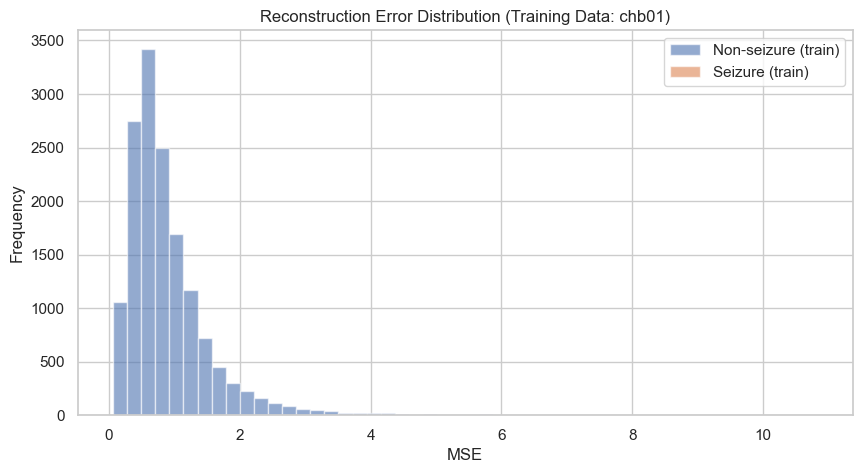

After SMOTE balancing: [14946    54]
chb01: Acc=0.9986, F1=0.0000, Sens=0.0000, FA/h=0.00, Time=579.6s
[INFO] Skipping chb02 (no seizures in test set)

Training Autoencoder on chb03...
Autoencoder Epoch [5/250] Loss: 0.990422
Autoencoder Epoch [10/250] Loss: 0.970061
Autoencoder Epoch [15/250] Loss: 0.962443
Autoencoder Epoch [20/250] Loss: 0.959058
Autoencoder Epoch [25/250] Loss: 0.955909
Autoencoder Epoch [30/250] Loss: 0.952606
Autoencoder Epoch [35/250] Loss: 0.951280
Autoencoder Epoch [40/250] Loss: 0.949335
Autoencoder Epoch [45/250] Loss: 0.947771
Autoencoder Epoch [50/250] Loss: 0.945824
Autoencoder Epoch [55/250] Loss: 0.942006
Autoencoder Epoch [60/250] Loss: 0.940562
Autoencoder Epoch [65/250] Loss: 0.938734
Autoencoder Epoch [70/250] Loss: 0.936822
Autoencoder Epoch [75/250] Loss: 0.936674
Autoencoder Epoch [80/250] Loss: 0.933093
Autoencoder Epoch [85/250] Loss: 0.933927
Autoencoder Epoch [90/250] Loss: 0.931197
Autoencoder Epoch [95/250] Loss: 0.931937
Autoencoder Epoch 

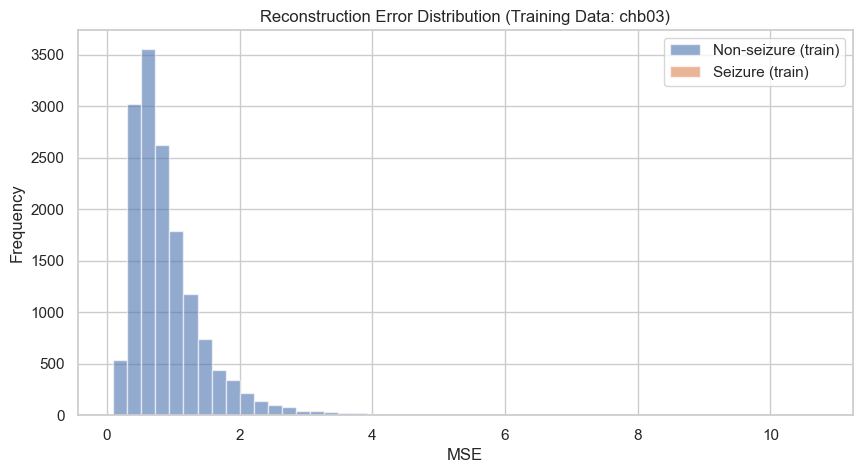

After SMOTE balancing: [14959 14959]
chb03: Acc=0.9960, F1=0.0000, Sens=0.0000, FA/h=0.00, Time=884.9s
[INFO] Skipping chb04 (no seizures in test set)

Training Autoencoder on chb05...
Autoencoder Epoch [5/250] Loss: 0.979051
Autoencoder Epoch [10/250] Loss: 0.954695
Autoencoder Epoch [15/250] Loss: 0.948582
Autoencoder Epoch [20/250] Loss: 0.945594
Autoencoder Epoch [25/250] Loss: 0.946894
Autoencoder Epoch [30/250] Loss: 0.942136
Autoencoder Epoch [35/250] Loss: 0.940673
Autoencoder Epoch [40/250] Loss: 0.937772
Autoencoder Epoch [45/250] Loss: 0.937198
Autoencoder Epoch [50/250] Loss: 0.934888


In [ ]:
print("Starting sequential LOSO evaluation with Autoencoder + XGBoost...")
df_results, y_true_all, y_pred_all = loso_xgb()
print("LOSO Sequential Evaluation Complete!")
print(df_results.describe().loc[["mean","std"]])

### --- Step 5: Visualization summary ---

In [ ]:
# Filter subjects with at least 1 seizure
df_plot = df_results[df_results["Seizure_Count"] > 0]

# Map of metrics for plotting
metrics_map = {
    "F1 Score": "F1",
    "Sensitivity": "Recall",
    "False Alarms per Hour": "False_Alarms_per_Hour"
}

# Plot bar charts for each metric
for metric_name, col_name in metrics_map.items():
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x="Subject", y=col_name, data=df_plot, palette="viridis", dodge=False)
    plt.title(f"{metric_name} per Subject", fontsize=16)
    plt.ylabel(metric_name, fontsize=12)
    plt.xlabel("Subject", fontsize=12)
    plt.xticks(rotation=45)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
# Global metrics
f1_global = f1_score(y_true_all, y_pred_all, zero_division=0)
sens_global = recall_score(y_true_all, y_pred_all, zero_division=0)
prec_global = precision_score(y_true_all, y_pred_all, zero_division=0)

print(f"\nGlobal F1 Score: {f1_global:.4f}")
print(f"Global Sensitivity: {sens_global:.4f}")
print(f"Global Precision: {prec_global:.4f}")

### --- Step 6: Feature Importance Visualization (from one subject) ---

In [ ]:
import joblib
# Load one subject model for demonstration
example_subject = "chb04"  # Choose the subject for demonstration
results_dir = "../data/results/Autoencoder_XGB"    # Directory where .joblib models are stored
feature_dir = "../data/features" # Directory where your .npy feature files are stored

# -------------------------------
# Load Trained Model
# -------------------------------
model_path = os.path.join(results_dir, f"xgb_model_{example_subject}.joblib")
clf_example = joblib.load(model_path)

# -------------------------------
# Load Feature Data (for shape reference)
# -------------------------------
for s in subjects:
    X_path = os.path.join(feature_dir, s, f"X_features_{s}.npy")
    if os.path.exists(X_path):
        X = np.load(X_path)
    else:
        print(f"Feature file for subject {s} not found.")

# -------------------------------
# Plot Feature Importance
# -------------------------------
importances = clf_example.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(15), importances[indices[:15]], align='center')
plt.xticks(range(15), indices[:15])
plt.title(f"Top 15 Feature Importances (Example Subject: {example_subject})")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()